# Profiling for dates associated with Nome storms

This notebook is for analyzing the results from profiling the analog forecast method using dates where Nome, AK was hit by a storm (provided by collaborators). 


The dates provided will be referred to as the "dates of interest." We applied the skill profiling framework for the the third and fifth days preceding the dates of interest. 

In [99]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
# local
import luts
from config import data_dir
import analog_forecast as af

Load and concatenate the results into single tables.

Analog and naive forecast results:

In [182]:
analog_df = pd.concat([
    pd.read_csv(fp) for fp in Path("results").glob("*.csv") 
    if (("naive" not in fp.name) and ("dates" not in fp.name))
])
naive_df = pd.concat([pd.read_csv(fp) for fp in Path("results").glob("*naive.csv")])

The top analogs were saved as separate tables, combine those as well:

In [183]:
analog_dates = pd.concat([pd.read_csv(fp) for fp in Path("results").glob("*dates.csv")])

## QC

First, some validation just to make sure we have things straight here. Let's take the first and last row here and manually check each aspect of the algorithm. 

In [184]:
row = analog_df.iloc[0]
row

variable                      t2m
spatial_domain             alaska
anomaly_search               True
reference_date         2004-10-08
forecast_day_number             1
forecast_error              4.851
Name: 0, dtype: object

Load the ERA5 data that we will use to search and generate forecasts:

In [185]:
%%time
varname = row["variable"]
ref_date = row["reference_date"]
ds = xr.load_dataset(data_dir.joinpath(luts.varnames_lu[varname]["anom_filename"]))

CPU times: user 86.8 ms, sys: 33 s, total: 33 s
Wall time: 50.2 s


Subset to the spatial domain:

In [186]:
spatial_domain = row["spatial_domain"]
bbox = luts.spatial_domains[spatial_domain]["bbox"]
sub_da = ds[varname].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2]))
print("Original shape:", ds[varname].shape)
print("Shape after spatial subset:", sub_da.shape)

Original shape: (23011, 361, 1440)
Shape after spatial subset: (23011, 129, 221)


Compute RMSE for all time slices before and after the reference date and forecast window:

In [187]:
%%time
analogs = af.find_analogs(sub_da, ref_date)

CPU times: user 5.14 s, sys: 3.4 s, total: 8.55 s
Wall time: 8.55 s


Load the raw value version for generating and checking the forecast:

In [188]:
%%time
raw_ds = xr.load_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))

CPU times: user 1min 39s, sys: 1min 41s, total: 3min 21s
Wall time: 3min 23s


Subset the raw data spatially and compute the forecast as the mean of the arrays for day t+1 for each of the analogs:

In [189]:
raw_sub_da = raw_ds[varname].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2]))
forecast = (raw_sub_da.sel(time=analogs.time.values + pd.to_timedelta(1, "d")).values).mean(axis=0)

Compute the RMSE between forecast and the date after the reference date, and cross check with the results:

In [190]:
test_rmse = np.sqrt(
    ((raw_sub_da.sel(
        time=pd.to_datetime(ref_date + " 12:00:00") + pd.to_timedelta(1, "d")
    ) - forecast) ** 2).mean()
).round(3)

assert test_rmse == row["forecast_error"].astype(np.float32)

Make sure memory is freed up for loading different datasets:

In [11]:
import gc
try:
    del ds
    del sub_da
    del raw_sub_da
    del raw_ds
except:
    pass
gc.collect()

75

Do the same as above for another row with some different variables, spatial domains, etc:

In [38]:
def validate_row(row):
    varname = row["variable"]
    ref_date = row["reference_date"]
    spatial_domain = row["spatial_domain"]
    bbox = luts.spatial_domains[spatial_domain]["bbox"]
    date_offset = row["forecast_day_number"]

    if row["anomaly_search"] == True:
        ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["anom_filename"]))
        search_da = af.spatial_subset(ds[varname], bbox)
        raw_ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))
        forecast_da = af.spatial_subset(raw_ds[varname], bbox)
    else:
        ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))
        search_da = forecast_da = af.spatial_subset(ds[varname], bbox)

    analogs = af.find_analogs(search_da, ref_date)

    forecast = (forecast_da.sel(time=analogs.time.values + pd.to_timedelta(date_offset, "d")).values).mean(axis=0)
    test_rmse = np.sqrt(
        ((forecast_da.sel(
            time=pd.to_datetime(ref_date + " 12:00:00") + pd.to_timedelta(date_offset, "d")
        ) - forecast) ** 2).mean()
    ).round(3)

    assert test_rmse == row["forecast_error"].astype(np.float32)

In [39]:
%%time
row = analog_df.query("variable == 'sst'").iloc[-1]
validate_row(row)

CPU times: user 1min 1s, sys: 55.6 s, total: 1min 56s
Wall time: 2min 1s


In [40]:
%%time
row = analog_df.query("variable == 'msl'").iloc[300]
validate_row(row)

CPU times: user 1min 41s, sys: 1min 55s, total: 3min 37s
Wall time: 3min 40s


In [41]:
%%time
analog_df.query("variable == 'z'").iloc[500]
validate_row(row)

CPU times: user 1min 39s, sys: 1min 44s, total: 3min 24s
Wall time: 3min 24s


## Create tables

Here we will create some useful tables from the CSVs containing results.

First we'll just show some snapshots of the tables. Here is a case where the naive forecast is clearly better than the analog forecast using anomaly-based search, but where the standard search-based forecast is comparable.

Naive:

In [132]:
query_str = "spatial_domain == 'alaska' & variable == 't2m' & reference_date == '2011-11-06'"
naive_df.query(query_str).head()

,variable,spatial_domain,reference_date,forecast_day_number,naive_2.5,naive_50,naive_97.5,forecast_date
98,t2m,alaska,2011-11-06,1,2.834,3.994,7.003,2011-11-07
99,t2m,alaska,2011-11-06,2,3.806,5.058,7.743,2011-11-08
100,t2m,alaska,2011-11-06,3,3.874,5.130,7.508,2011-11-09
101,t2m,alaska,2011-11-06,4,3.365,4.566,7.224,2011-11-10
102,t2m,alaska,2011-11-06,5,3.408,4.393,7.277,2011-11-11


Anomaly-based search:

In [135]:
analog_df.query(query_str + " & anomaly_search == True").head()

,variable,spatial_domain,anomaly_search,reference_date,forecast_day_number,forecast_error,forecast_date
98,t2m,alaska,True,2011-11-06,1,10.526,2011-11-07
99,t2m,alaska,True,2011-11-06,2,12.041,2011-11-08
100,t2m,alaska,True,2011-11-06,3,11.862,2011-11-09
101,t2m,alaska,True,2011-11-06,4,10.331,2011-11-10
102,t2m,alaska,True,2011-11-06,5,10.547,2011-11-11


Without the anomaly search, actually better for first couple of days:

In [136]:
analog_df.query(query_str + " & anomaly_search == False").head()

,variable,spatial_domain,anomaly_search,reference_date,forecast_day_number,forecast_error,forecast_date
98,t2m,alaska,False,2011-11-06,1,2.954,2011-11-07
99,t2m,alaska,False,2011-11-06,2,3.873,2011-11-08
100,t2m,alaska,False,2011-11-06,3,5.382,2011-11-09
101,t2m,alaska,False,2011-11-06,4,6.366,2011-11-10
102,t2m,alaska,False,2011-11-06,5,6.700,2011-11-11


### Saving tables

Now we will create and save some tables for collaborators to have a look at.

First, we are interested in looking at results for only a couple of key dates, and we want all of the forecast days available. We will do some things to make more user-friendly tables as well. 

Analog results:

In [171]:
# we want the reference dates that include these keep dates in the forecast
keep_dates = ["2004-10-11", "2011-11-09"]
analog_df["forecast_date"] = (pd.to_datetime(analog_df["reference_date"]) + pd.to_timedelta(analog_df["forecast_day_number"], unit="d"))
keep_ref_dates = analog_df.query("forecast_date in @keep_dates").reference_date
analog_df_subset = analog_df.query("reference_date in @keep_ref_dates").drop(columns="forecast_day_number")[
    # re-order columns
    ["variable", "spatial_domain", "anomaly_search", "reference_date", "forecast_date", "forecast_error"]
]
# main attributes to sort on
main_attrs = ["variable", "spatial_domain", "anomaly_search", "reference_date"]
analog_df_subset = analog_df_subset.sort_values(main_attrs)
analog_df_subset

,variable,spatial_domain,anomaly_search,reference_date,forecast_date,forecast_error
112,msl,alaska,False,2004-10-06,2004-10-07,563.366
113,msl,alaska,False,2004-10-06,2004-10-08,1037.702
114,msl,alaska,False,2004-10-06,2004-10-09,1361.240
115,msl,alaska,False,2004-10-06,2004-10-10,1217.323
116,msl,alaska,False,2004-10-06,2004-10-11,1273.240
...,...,...,...,...,...,...
555,z,panarctic,True,2011-11-06,2011-11-16,2006.701
556,z,panarctic,True,2011-11-06,2011-11-17,1986.115
557,z,panarctic,True,2011-11-06,2011-11-18,1963.677
558,z,panarctic,True,2011-11-06,2011-11-19,2051.765


We will provide a table of top analogs to go along with this. We want this to be sorted in the same manner for ease of use.

In [174]:
top_dates = analog_dates.loc[analog_dates.groupby(main_attrs).analog_score.idxmin()]
top_dates_subset = top_dates.query("reference_date in @keep_ref_dates").drop_duplicates().sort_values(main_attrs)
top_dates_subset

,variable,spatial_domain,anomaly_search,reference_date,analog_date,analog_score
40,msl,alaska,False,2004-10-06,1995-10-09,418.226
0,msl,alaska,False,2004-10-08,1962-10-05,650.330
75,msl,alaska,False,2011-11-04,2014-06-17,438.475
35,msl,alaska,False,2011-11-06,2020-08-06,428.098
40,msl,alaska,True,2004-10-06,1988-05-30,440.451
...,...,...,...,...,...,...
195,z,panarctic,False,2011-11-06,1999-11-07,1019.425
200,z,panarctic,True,2004-10-06,1989-05-31,805.669
160,z,panarctic,True,2004-10-08,1982-06-06,722.459
235,z,panarctic,True,2011-11-04,2005-07-09,784.444


Do the same thing as above with the naive forecast results to get a table for comparison:

In [173]:
naive_df["forecast_date"] = (pd.to_datetime(naive_df["reference_date"]) + pd.to_timedelta(naive_df["forecast_day_number"], unit="d"))
naive_df_subset = naive_df.query("reference_date in @keep_ref_dates.unique()").drop(columns="forecast_day_number")[
    # re-order columns
    ["variable", "spatial_domain", "reference_date", "forecast_date", "naive_2.5", "naive_50", "naive_97.5"]
# no anomaly_search option for naive forecasting
].sort_values(["variable", "spatial_domain", "reference_date"])
naive_df_subset

,variable,spatial_domain,reference_date,forecast_date,naive_2.5,naive_50,naive_97.5
112,msl,alaska,2004-10-06,2004-10-07,685.106,1007.567,1408.459
113,msl,alaska,2004-10-06,2004-10-08,984.755,1316.444,1715.134
114,msl,alaska,2004-10-06,2004-10-09,958.944,1400.313,1883.607
115,msl,alaska,2004-10-06,2004-10-10,902.990,1303.966,1743.587
116,msl,alaska,2004-10-06,2004-10-11,905.824,1309.384,1728.522
...,...,...,...,...,...,...,...
555,z,panarctic,2011-11-06,2011-11-16,1029.253,1270.653,1560.759
556,z,panarctic,2011-11-06,2011-11-17,1083.532,1320.347,1585.097
557,z,panarctic,2011-11-06,2011-11-18,1063.035,1308.062,1597.460
558,z,panarctic,2011-11-06,2011-11-19,1081.221,1309.220,1571.216


Now save these tables. Going to include the date of creation here to help track the potentially many tables we could end up generating:

In [178]:
from datetime import datetime
Path("tables").mkdir(exist_ok=True)
today = datetime.today().strftime('%Y%m%d')
analog_df_subset.to_csv(f"tables/analog_profiling_results_{today}.csv", index=False)
top_dates_subset.to_csv(f"tables/profiling_top_analogs_{today}.csv", index=False)
naive_df_subset.to_csv(f"tables/naive_profiling_results_{today}.csv", index=False)

## Visualize results

Do some general charting of results. We don't have any specific requests here yet to support the research, so we will just create a few line charts to share.

### Error over time

Generate some line charts of error over time for a variety of combinations:

In [166]:
def plot_error_by_fday_line_chart(varname, spatial_domain, ref_date):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    query_str = "spatial_domain == @spatial_domain & variable == @varname & reference_date == @ref_date"
    plot_df = naive_df.query(query_str)[["forecast_date", "naive_2.5", "naive_50", "naive_97.5"]].set_index("forecast_date")
    plot_df = plot_df.join(
        analog_df.query(
            query_str + " & anomaly_search == True"
        )[["forecast_date", "forecast_error"]].set_index("forecast_date").rename(
            columns={"forecast_error": "anom_forecast_error"}
        )
    )
    plot_df = plot_df.join(
        analog_df.query(
            query_str + " & anomaly_search == False"
        )[["forecast_date", "forecast_error"]].set_index("forecast_date").rename(
            columns={"forecast_error": "forecast_error"}
        )
    )
    plot_df.plot(title=f"{varname},  {spatial_domain},  Reference Date: {ref_date}", ax=ax)
    ax.set_ylabel("RMSE")


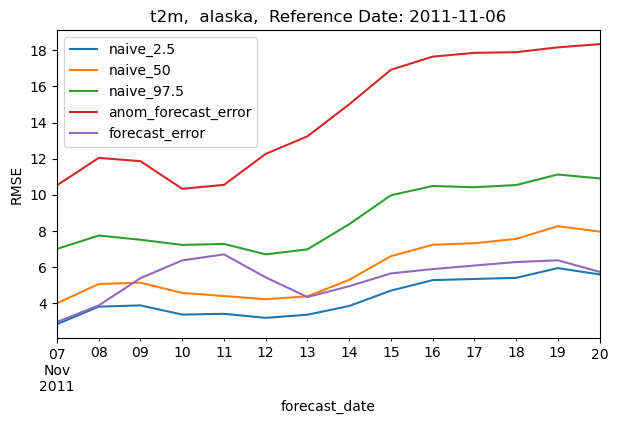

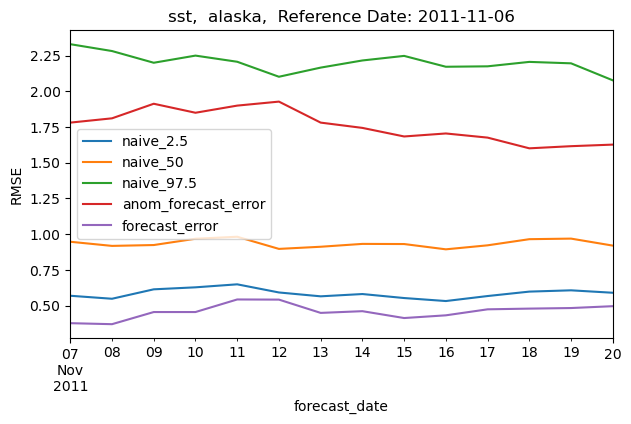

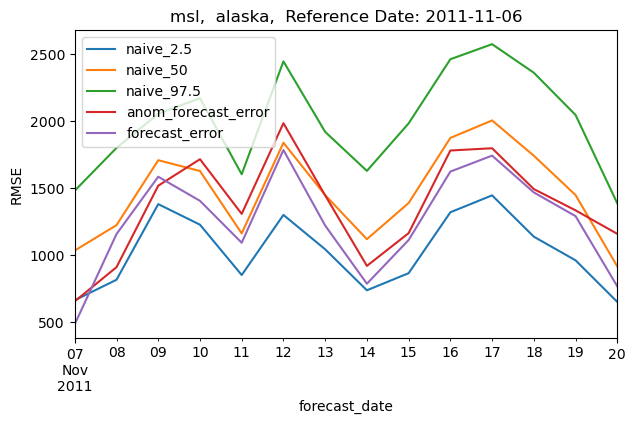

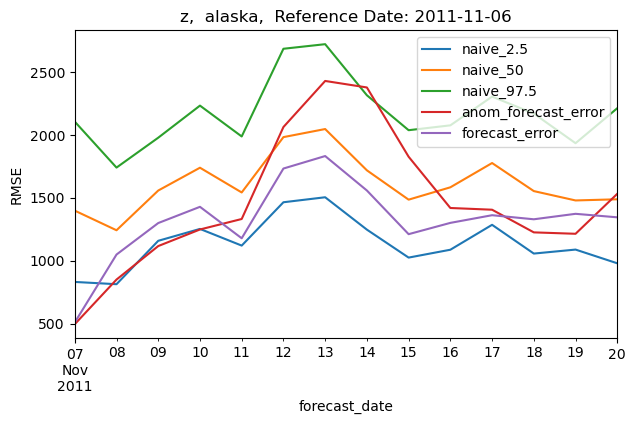

In [180]:
plot_error_by_fday_line_chart("t2m", "alaska", "2011-11-06")
plot_error_by_fday_line_chart("sst", "alaska", "2011-11-06")
plot_error_by_fday_line_chart("msl", "alaska", "2011-11-06")
plot_error_by_fday_line_chart("z", "alaska", "2011-11-06")

Now for a couple other spatial domains:

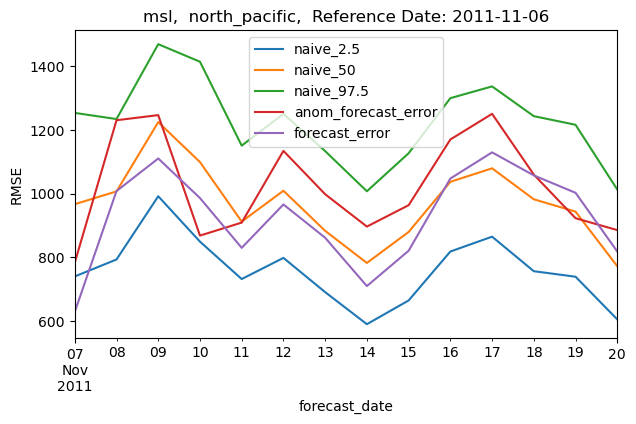

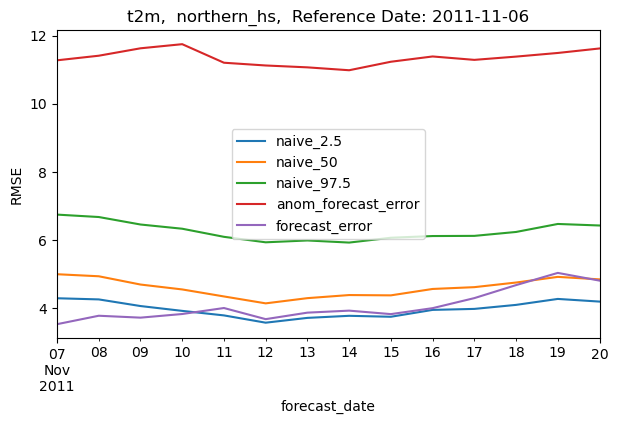

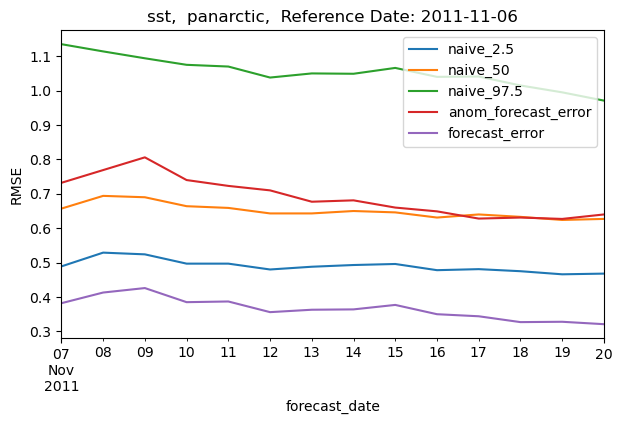

In [179]:
plot_error_by_fday_line_chart("msl", "north_pacific", "2011-11-06")
plot_error_by_fday_line_chart("t2m", "northern_hs", "2011-11-06")
plot_error_by_fday_line_chart("sst", "panarctic", "2011-11-06")